### Outlier Factors for Device Profiling

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=10000)

df.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.sort_index(inplace=True)
df.head()

,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [2]:
from sklearn.preprocessing import MinMaxScaler

def scale(x):
    return np.log(x + 1)
   

class customScaler():
    def __init__(self, feature_range=(1,100)):
        self.feature_range = feature_range
    
    def fit(self, x):
        scaled_data = scale(x)
        self.scaler = MinMaxScaler(feature_range=self.feature_range)
        self.scaler.fit(scaled_data)

    def transform(self, data):
        scaled_data = scale(data)
        transformed = self.scaler.transform(scaled_data).astype(int)
        return np.array(transformed, dtype=np.int64)

In [3]:
from helper import get_data_by_dataframe, get_random_initialize_lamdas

scaler = customScaler()
data_by_host, hosts = get_data_by_dataframe(df, size_of_bin_seconds=50, doScale=True, scaler=scaler)

In [4]:
import itertools

all_data = list(itertools.chain(*list(data_by_host.values())))

In [5]:
from emClustering import OnlineEM
from plots import plot_points, plot_results

In [6]:
from helper import get_random_initialize_lamdas

mixtures = 5

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, get_random_initialize_lamdas(all_data, number_of_mixtures=mixtures), 500, n_clusters=4)
onlineEM.fit(data_by_host)

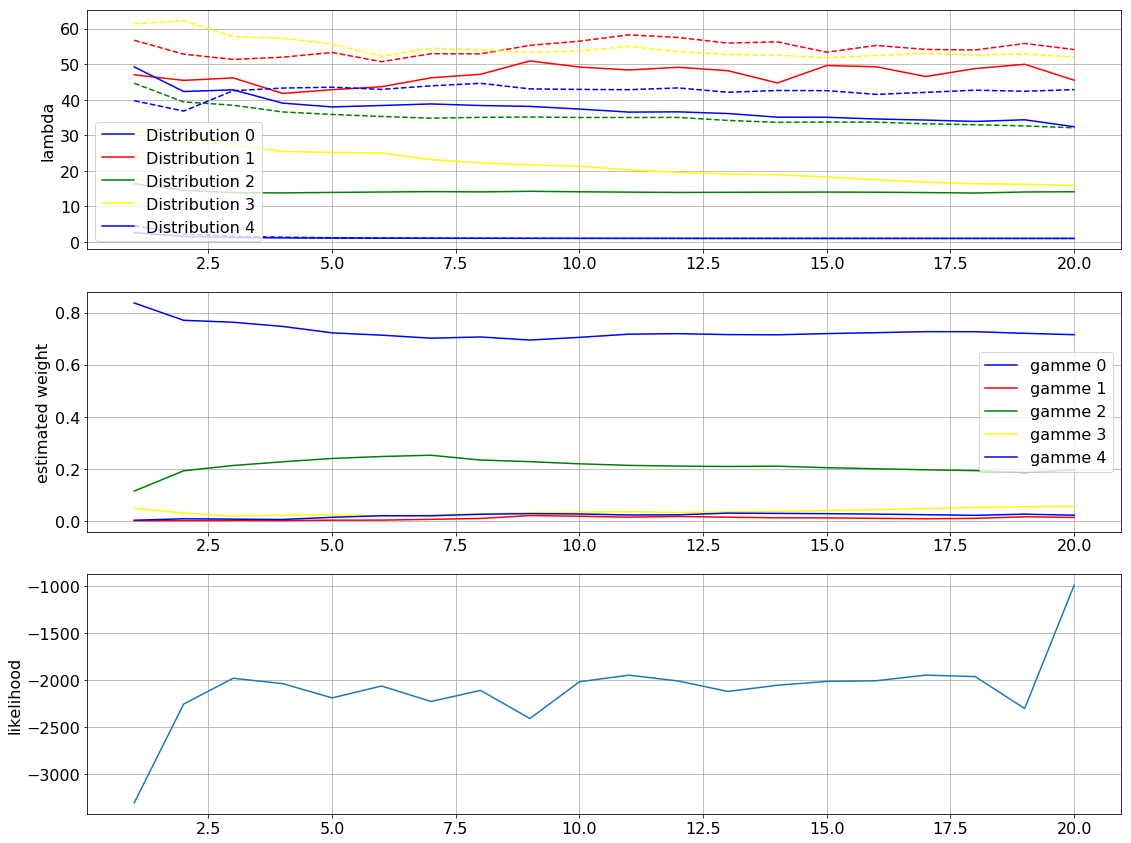

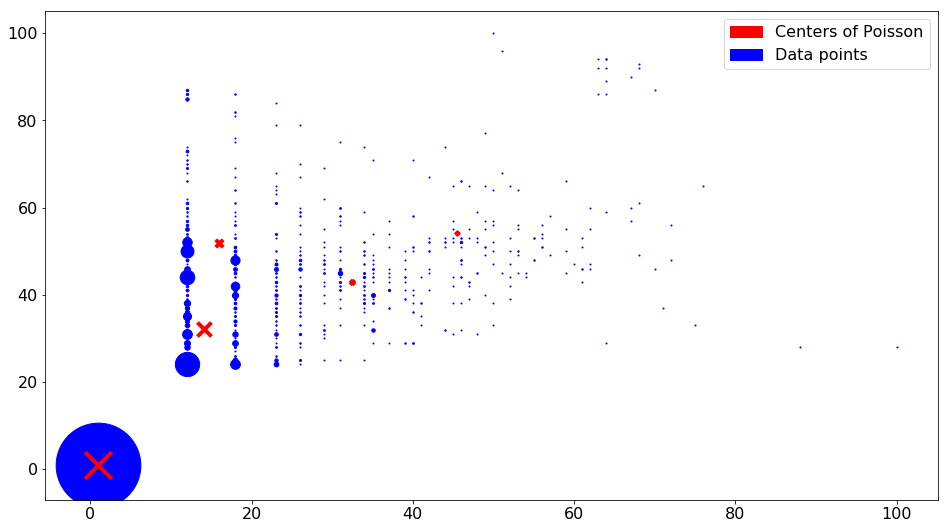

In [7]:
plot_results(onlineEM)
plot_points(all_data, onlineEM)

In [8]:
onlineEM.lambdas

array([[  1.00186517,   1.00407957],
       [ 45.47798942,  54.1032261 ],
       [ 14.12557099,  32.0962707 ],
       [ 15.9212056 ,  51.9754418 ],
       [ 32.39955283,  42.83804151]])

In [30]:
onlineEM.threshold = 0.0000000001

In [31]:
results = onlineEM.score_anomaly(data_by_host)

In [32]:
np.sum(results)

17

In [34]:
np.where(results == True)

(array([4123, 4400, 4401, 4402, 4403, 4405, 4406, 4407, 7331, 7332, 9008,
        9009, 9010, 9011, 9013, 9015, 9146], dtype=int64),)

In [41]:
hosts[515]

'C4858'

In [45]:
all_data[4123]

array([71, 37], dtype=int64)

In [42]:
data_by_host['C4858']

array([[ 1,  1],
       [45, 38],
       [ 1,  1],
       [71, 37],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1],
       [ 1,  1]], dtype=int64)

In [43]:
onlineEM.hosts['C4858']

{'category': 1,
 'group': array([  7.50000000e-01,   1.65477466e-01,   3.17162057e-09,
          6.84788352e-09,   8.45225243e-02]),
 'n_points': 8}

In [44]:
onlineEM.lambdas

array([[  1.00186517,   1.00407957],
       [ 45.47798942,  54.1032261 ],
       [ 14.12557099,  32.0962707 ],
       [ 15.9212056 ,  51.9754418 ],
       [ 32.39955283,  42.83804151]])

In [49]:
def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

import scipy.stats.distributions

host = 'C4858'
f = np.zeros(shape=(len(data_by_host[host]), onlineEM.m))

for i, x_i in enumerate(data_by_host[host]):
    f[i] = onlineEM.gammas * np.array([poisson(x_i, lambda_i) for lambda_i in onlineEM.lambdas])

In [60]:
gammas_for_cluster = onlineEM.probabilities_per_kMean_cluster[onlineEM.hosts[host]['category']]

In [61]:
np.max(f * gammas_for_cluster, axis=1) < onlineEM.threshold

array([False, False, False,  True, False, False, False, False], dtype=bool)